#  Resnet model - Cosine Similarity

This file contains the implementation of the Transfer Learning Resnet model and the cosine similarity 

In [1]:
# Import libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet50
import torch.nn.functional as F
from PIL import Image
import os
import warnings

warnings.filterwarnings('always') 

EPOCHS = 5
LEARNING_RATE = 0.0001
BATCH_SIZE = 32

In [2]:
# Set GPU/MPS growth for the model training
device = torch.device('mps')

In [3]:
# Path to the train and evaluation folders
train_data_folder = './train'
test_data_folder = './test'

# Number of classes is equal to the number of videos we have as data
num_classes = len(os.listdir(train_data_folder))     



# Load and transform the training dataset
data_transform = {
    'train': transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
    transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]),

    'test': transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
}


# Load and transform the training and evaluation dataset
train_dataset = torchvision.datasets.ImageFolder(root=train_data_folder, transform=data_transform['train'])
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_dataset = torchvision.datasets.ImageFolder(root=test_data_folder, transform=data_transform['test'])
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [4]:
# Create a training results file
training_file = open('train.txt', 'a')

# Load the pre-trained ResNet-50 model
model = resnet50(pretrained=True)

# Freeze the initial layers
for param in model.parameters():
    param.requires_grad = False

# Replace the last fully connected layer to match the number of classes
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, num_classes)

# Move the model to the device (GPU/CPU)
model = model.to(device)


# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Train the model
total_step = len(train_loader)


for epoch in range(EPOCHS):
    correct = 0
    total_samples = 0

    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print training progress
        if (i + 1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{EPOCHS}], Step [{i+1}/{total_step}], Loss: {loss.item():.4f}')


        # Compute predictions
        with torch.no_grad():
            outputs = model(images)
            _, predicted = torch.topk(outputs, k=10, dim=1)
            total_samples += labels.size(0)
            correct += (predicted == labels.view(-1, 1)).sum().item()

    # Calculate top-5 accuracy
    accuracy = correct / total_samples

    # Print precision and recall per epoch
    print(f'Epoch [{epoch+1}/{EPOCHS}] - Top 10 Accuracy : {accuracy:.4f}')
    training_file.writelines(f'Epoch [{epoch+1}/{EPOCHS}] - Top 10 Accuracy: {accuracy:.4f}\n')


training_file.close()
print('Training finished.')

# Save the trained model
os.makedirs('saved_models', exist_ok=True)
torch.save(model.state_dict(), 'saved_models/resnet50_trained.pth')

/opt/homebrew/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/5], Step [100/691], Loss: 4.1899
Epoch [1/5], Step [200/691], Loss: 3.9887
Epoch [1/5], Step [300/691], Loss: 3.6721
Epoch [1/5], Step [400/691], Loss: 3.8602
Epoch [1/5], Step [500/691], Loss: 3.5982
Epoch [1/5], Step [600/691], Loss: 3.4348
Epoch [1/5] - Top 10 Accuracy : 0.5578
Epoch [2/5], Step [100/691], Loss: 3.2182
Epoch [2/5], Step [200/691], Loss: 3.2296
Epoch [2/5], Step [300/691], Loss: 2.4814
Epoch [2/5], Step [400/691], Loss: 2.8683
Epoch [2/5], Step [500/691], Loss: 2.7913
Epoch [2/5], Step [600/691], Loss: 3.0112
Epoch [2/5] - Top 10 Accuracy : 0.8125
Epoch [3/5], Step [100/691], Loss: 2.2866
Epoch [3/5], Step [200/691], Loss: 2.6200
Epoch [3/5], Step [300/691], Loss: 2.2400
Epoch [3/5], Step [400/691], Loss: 2.3072
Epoch [3/5], Step [500/691], Loss: 2.5109
Epoch [3/5], Step [600/691], Loss: 2.2841
Epoch [3/5] - Top 10 Accuracy : 0.8606
Epoch [4/5], Step [100/691], Loss: 1.8259
Epoch [4/5], Step [200/691], Loss: 1.9766
Epoch [4/5], Step [300/691], Loss: 2.4730
E

### Import the saved model and get the Linear Layer

In [5]:
# Load the saved model dictionary
model_state = torch.load('saved_models/resnet50_trained.pth')

# Create a new instance of the ResNet-50 model and get the Linear Layer as the feature vector
new_model = resnet50(pretrained=False)
num_features = new_model.fc.in_features
new_model.fc = nn.Linear(num_features, num_classes)

# Define the new model and use the training results of the model we just trained
new_model.load_state_dict(model_state)
new_model.to(device)
new_model.eval()

/opt/homebrew/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

#### Define the similarity function

In [6]:
# Define cosine similarity function
def cosine_similarity(test_image_features, train_data_features, dim=1, eps=1e-8):
    dot_product = torch.sum(test_image_features * train_data_features, dim=dim)
    norm_test = torch.norm(test_image_features, dim=dim)
    norm_data = torch.norm(train_data_features, dim=dim)
    return dot_product / (norm_test * norm_data).clamp(min=eps)

### Load data

In [7]:
# Load the data, in order to extract the features
train_dataset = torchvision.datasets.ImageFolder(root=train_data_folder, transform=data_transform['train'])
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)

### Get the feature vectors for each of the data class

In [8]:
# Get the features of all images and set them with the labels
train_features = []
train_labels = []

with torch.no_grad():
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        features = new_model(images)
        train_features.append(features)
        train_labels.append(labels)

train_features = torch.cat(train_features, dim=0)
train_labels = torch.cat(train_labels, dim=0)

./train/gomez_it_ain_t_me/gomez_it_ain_t_me_158.png
./train/farruko_pepas/farruko_pepas_128.png
./train/gomez_it_ain_t_me/gomez_it_ain_t_me_32.png
./train/gomez_it_ain_t_me/gomez_it_ain_t_me_81.png
./train/farruko_pepas/farruko_pepas_83.png
./train/powfu_death_bed/powfu_death_bed_4.png
./train/music_sessions_53/music_sessions_53_163.png
./train/farruko_pepas/farruko_pepas_90.png
./train/gomez_it_ain_t_me/gomez_it_ain_t_me_38.png
./train/x_j_i_d_enemy/x_j_i_d_enemy_153.png


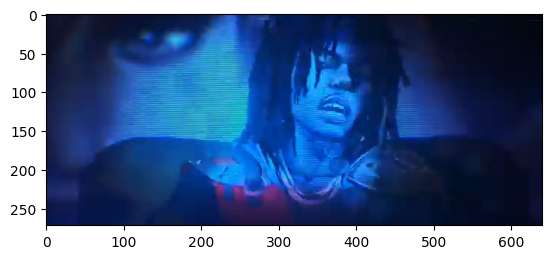

In [14]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


# Get the test image
image_to_compare = data_transform['test'](Image.open('/Users/stamatiosorphanos/Documents/MultiModal-Deep-Learning/MultiModal/test_image.jpeg')).unsqueeze(0).to(device)

# Normalize both train and test image feature vectors
normalized_train_features = F.normalize(train_features, p=2, dim=1)
normalized_image_features = F.normalize(new_model(image_to_compare), p=2, dim=1)

# Cosine Similarity for the top 10 most similar frames
cos_similarities = cosine_similarity(normalized_image_features, normalized_train_features)
top_k_results = torch.topk(cos_similarities, k=10).indices

# List of most similar images 
similar_image_paths = [train_dataset.samples[idx][0] for idx in top_k_results]

for similar_image in similar_image_paths:
    print(similar_image)
